# Imports

In [399]:
import random
random.seed(24071992)
import numpy as np
np.random.seed(24071992)
import matplotlib
import matplotlib.pyplot as plt
import scipy.spatial
import pandas as pd
import pickle
from astropy.stats import RipleysKEstimator
from collections import Counter
import itertools
import networkx as nx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook

# Basic function (test data)

<IPython.core.display.Javascript object>


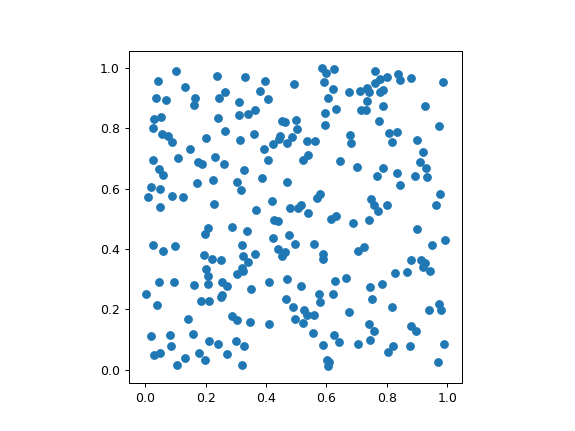

In [32]:
cells = np.random.rand(250,2)
plt.figure()
plt.scatter(cells[:,0], cells[:,1])
plt.gca().set_aspect('equal')

In [40]:
#Generate labels
labels = np.zeros((1,len(cells)), dtype='int64')
for i, c in enumerate(cells):
    labels[0,i] = int(random.random() + c[0])
labels = labels[0]

<IPython.core.display.Javascript object>


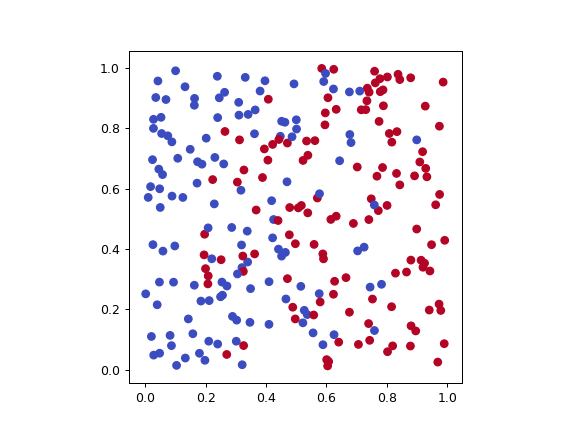

In [41]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

In [43]:
x = scipy.spatial.KDTree(cells, leafsize=10)

<IPython.core.display.Javascript object>


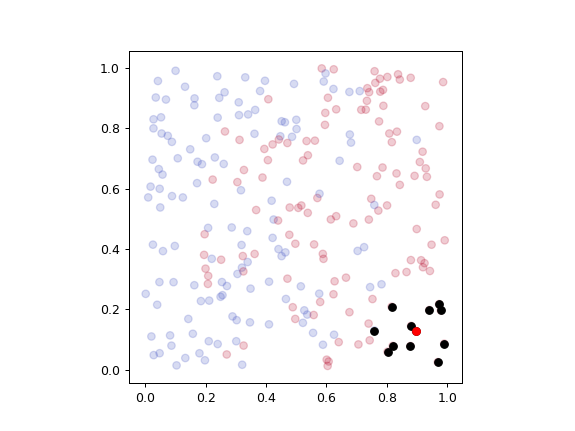

In [9]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels, cmap=matplotlib.cm.coolwarm, alpha=0.2)
cell = 1
neighbours = x.query(cells[cell], k=12)[1]
for c in neighbours:
    plt.scatter(cells[c, 0], cells[c, 1], c='black')
plt.scatter(cells[cell, 0], cells[cell, 1], c='red')
plt.gca().set_aspect('equal')

In [97]:
x = scipy.spatial.KDTree(cells, leafsize=10)

In [10]:
labels_1 = np.zeros_like(labels)
for i, c in enumerate(cells):
    neighbours = x.query(cells[i], k=12)[1]
    most_common_label = np.argmax(np.bincount(labels[neighbours]))
    labels_1[i] = most_common_label
    

<IPython.core.display.Javascript object>


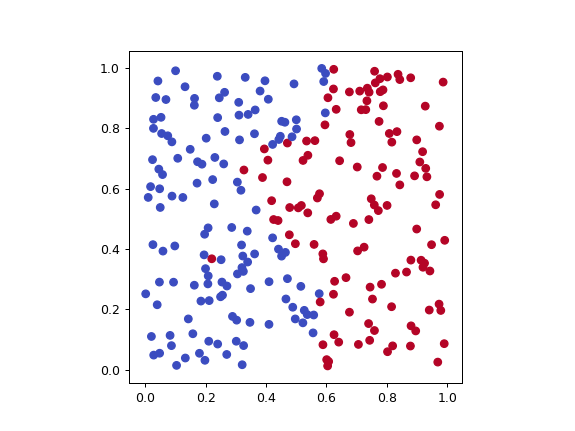

In [11]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels_1, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

In [13]:
labels_2 = np.zeros_like(labels)
for i, c in enumerate(cells):
    neighbours = x.query(cells[i], k=12)[1]
    most_common_label = np.argmax(np.bincount(labels_1[neighbours]))
    labels_2[i] = most_common_label

<IPython.core.display.Javascript object>


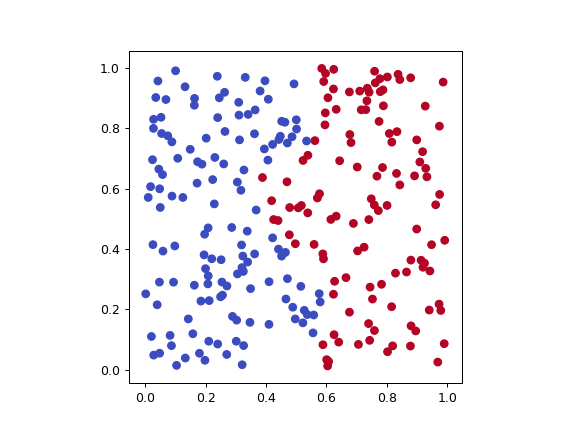

In [14]:
plt.figure()
plt.scatter(cells[:,0], cells[:,1], c=labels_2, cmap=matplotlib.cm.coolwarm)
plt.gca().set_aspect('equal')

# Cortex regionalization

## Data import

In [2]:
df_fish_totmol_clean = pickle.load(open("df_fish_totmol_clean.p", 'rb'))
df_coord = pickle.load(open("Cell_coordinates.p", 'rb'))
df_coord = df_coord.loc[:,df_fish_totmol_clean.columns]
labels_a = pickle.load(open("labels_a_df_fish_totmol_clean.p", 'rb'))

In [3]:
x_min = df_coord.loc['X'].min()
x_max = df_coord.loc['X'].max()
y_min = df_coord.loc['Y'].min()
y_max = df_coord.loc['Y'].max()
area = ((x_max-x_min)*(y_max-y_min))
Kest = RipleysKEstimator(area, x_max, y_max, x_min, y_min)
radii = np.linspace(1000,20000, 100)

In [4]:
RK_500 = []
RK_750 = []
RK_1000 = []
RK_3000 = []
RK_7000 = []
RK_10000 = []
for i in np.sort(np.unique(labels_a)):
    filt = labels_a == i
    estimate =  Kest(data=np.array(df_coord.loc[:,filt].T), radii=radii, mode='none')
    RK_500.append(estimate[np.argmin(np.abs(radii - 500))]) 
    RK_750.append(estimate[np.argmin(np.abs(radii - 750))]) 
    RK_1000.append(estimate[np.argmin(np.abs(radii - 1000))]) 
    RK_3000.append(estimate[np.argmin(np.abs(radii - 3000))]) 
    RK_7000.append(estimate[np.argmin(np.abs(radii - 7000))]) 
    RK_10000.append(estimate[np.argmin(np.abs(radii - 10000))]) 
    
    #Get the estimate of the radii closest to 3000 and append list

In [5]:
def plot_cell_pos(coordinate_df, cell_ids=None, cell_of_interest=None, color='gray', color_highlight1='r', color_highlight2='r', s=5, standalone = True, mode='Highlight'):
    """
    Plot the centroids of all cells in grey. A selection of cells can be made red.
    And one cell of interest can be shown larger with a white border around.
    Input:
    `coordinate_df`(pd df): Pandas df with cells in columns, and 'X' & 'Y' as rows.
    `cell_ids`(list): If selection of cells to plot, enter a list of cell ids. Default = None
    `color`(str): color of cells, default gray
    `s`(float): Size of dots. Default = 5
    `stanalone`(bool): If true it creates a figure. If false it can be used as subplot
    `mode`(str): if 'highlight' it is possible to highlight a group of cells and/or one cell
    `color_highlight1`: color of group of cells. default='r' 
    `color_highlight2`: color of single cells. default='r'
    
    """
    if standalone == True:
        plt.figure(figsize=(7,7))
        
    if mode.lower() == 'tsne':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
    
    if mode.lower() == 'highlight':
        plt.scatter(coordinate_df.loc['X',:], coordinate_df.loc['Y',:], linewidths=0, c=color, s=s)
        if cell_ids != None:
            plt.scatter(coordinate_df.loc[:,cell_ids].loc['X'], coordinate_df.loc[:,cell_ids].loc['Y'], color=color_highlight1, s=s*2)
        if cell_of_interest != None:
            plt.scatter(coordinate_df.loc[:,cell_of_interest][0], coordinate_df.loc[:,cell_of_interest][1], color=color_highlight2, s=s*8, lw=2, edgecolor='w')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.gca().axis('equal')
    plt.xlim([coordinate_df.loc['X'].max(), coordinate_df.loc['X'].min()])
    plt.ylim([coordinate_df.loc['Y'].max(), coordinate_df.loc['Y'].min()])
    plt.gca().patch.set_facecolor((.9,.9,.9))
    

<IPython.core.display.Javascript object>


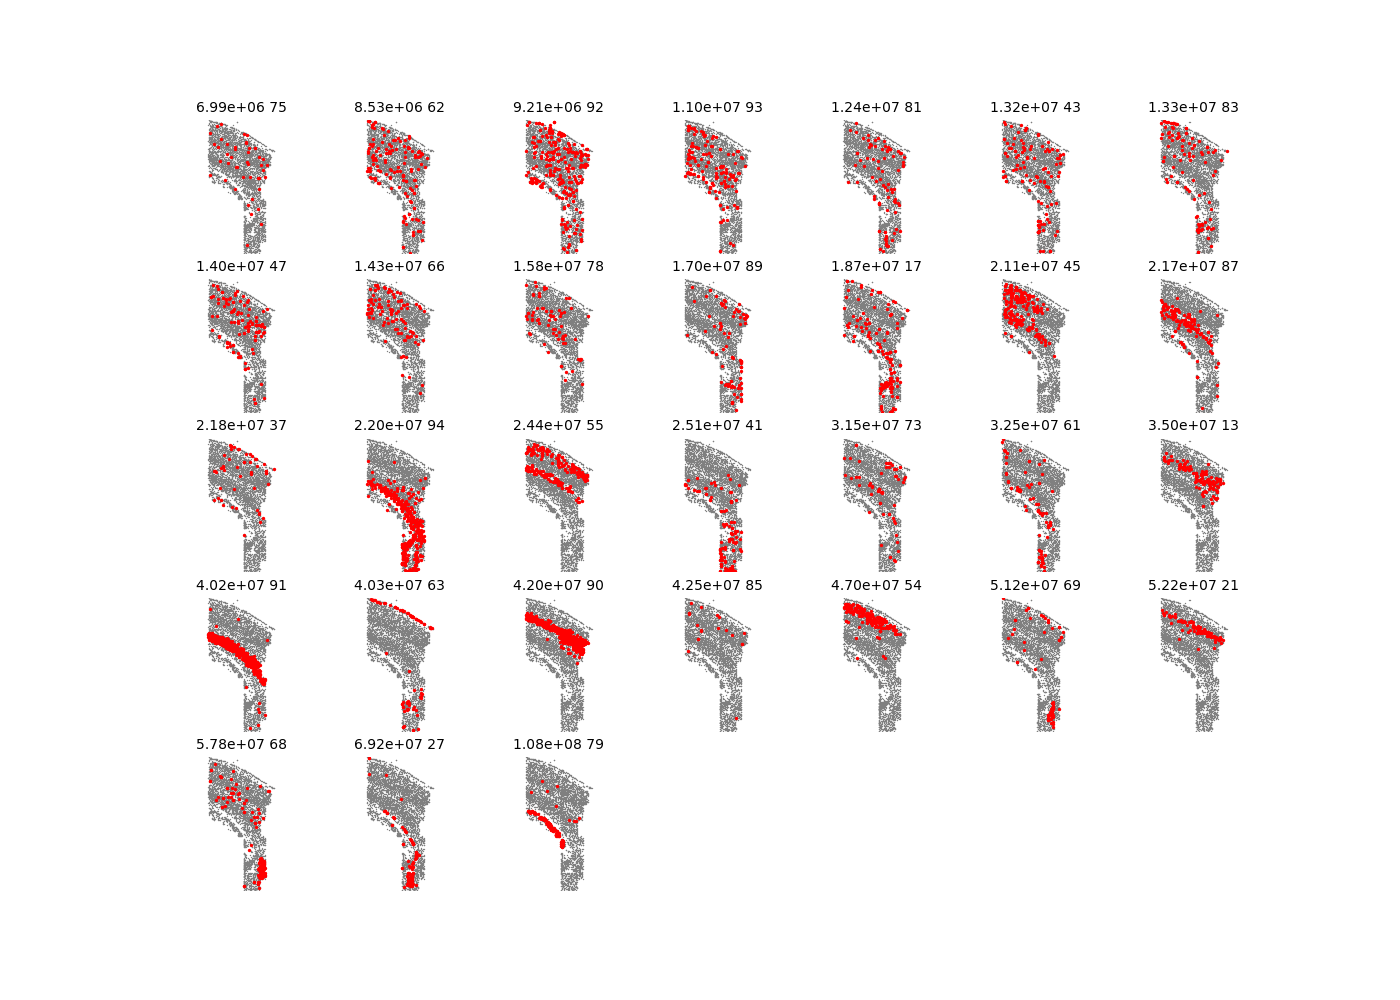

In [780]:
plt.figure(figsize=(14,10))
n_clusters = len(np.unique(labels_a))
gs = plt.GridSpec(5, int(n_clusters/5) + (n_clusters % 5 > 0))

RK_dist = RK_750

for i, c in enumerate([np.unique(labels_a)[i] for i in np.argsort(RK_dist)]):
    plt.subplot(gs[i])
    filt = labels_a == c
    plot_cell_pos(df_coord, cell_ids=list(df_fish_totmol_clean.columns[filt]), cell_of_interest=None, s=1, standalone=False, color_highlight1='r')
    plt.gca().set_axis_off()
    plt.title('{} {}'.format("{:.2e}".format(RK_dist[np.argsort(RK_dist)[i]]),c), fontsize=10)

In [777]:
RK_cutoff = 2.2e7
spatial_clusters = [np.unique(labels_a)[n] for n,i in enumerate(RK_750) if i>RK_cutoff]
spatial_clusters

[13, 21, 27, 41, 54, 55, 61, 63, 68, 69, 73, 79, 85, 90, 91, 94]

In [790]:
manual_spatial_clusters = [79,27,68,69,54,90,63,91,61,94,87,55]

In [334]:
combinations_dict = {}
for n, i in enumerate(np.unique(labels_a)):
    combinations_dict[str(i)] = n+1
    
for n, i in enumerate(itertools.combinations(np.unique(labels_a), 2)):
    name = '{}_{}'.format(i[0], i[1])
    combinations_dict[name] = n+len(np.unique(labels_a)) +1 


In [346]:
n = [12,12,12,12,14,15,1,16]
per = [(Counter(n)[i] / len(n)  * 100) for i in Counter(n)]

top_labels = []
for i in np.argsort(per)[:1:-1]:
    if per[i] > 20:
        top_labels.append(list(Counter(n).keys())[i])
        
if len(top_labels) == 1:
    name = str(top_labels[0])
if len(top_labels) == 2:
    name = '{}_{}'.format(sorted(top_labels)[0], sorted(top_labels)[1])
    
name

'12'

In [1151]:
def regionalization(cell_coordinates, labels, neighbors, cycles=None, max_dist=np.inf, included_clusters=None,
                   reset_label_round=None, reset_count_cutoff=None, merge_labels=False,
                   remove_islands = True, remove_island_round = [], island_max_dist = np.inf,
                   island_minimal_group=100, post_split=False, force_id = False, 
                    force_id_cutoff = 10):
    """
    Regionalize the sample by converting all cells to the identity of the cell type with the
    highest regional density. 
    
    """
    
    def reset_labels(label_matrix, count_threshold, reset_to_9999=False):
        """
        Reset the labels of clusters that are present in low numbers to the original labels.
        Input:
        `label_matrix`(pandas dataframe): Dataframe with labels in rows for each iteration 
            and cells in columns
        `count_threshold`(int): Number or cells with a specific label to be resit
        `reset_to_zero`(bool): Does not reset to the original labels but to 9999. 
            9999 should not be included in the included_clusters.
        Returns:
        Array of reset labels
        
        """
        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        new_label = 'Reset_labels'
        for i in np.unique(label_matrix.iloc[-1]):
            if list(label_matrix.iloc[-1]).count(i) < count_threshold:
                filt = label_matrix.iloc[-1] == i
                if reset_to_9999 == False:
                    label_matrix.loc[last_label,filt] = label_matrix.loc[first_label,filt]
                else:
                    label_matrix.loc[last_label,filt] = [9999] * label_matrix.loc[last_label].value_counts()[i]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    def max_dist_graph(coordinates, max_dist=np.inf):
        """
        Build a graph with the coordinates as nodes and edges if the nodes are 
        within the max_dist from each other
        Input:
        `coordinates`(array): Array with the coordinates from each node.
        `max_dist`(float): Max distance nodes can be spaced from each other to 
            be connected.
        Retruns:
        A networkx graph

        """
        #Transpose coordinate df if X and Y are in the rows
        if coordinates.shape[0] == 2:
            coordinates = coordinates.T

        #Built the KDTree
        nn_tree = scipy.spatial.KDTree(coordinates, leafsize=10)

        #Find the pairs of nodes within the max_dist
        cell_pairs = [[coordinates.index[j] for j in i] for i in nn_tree.query_pairs(max_dist)]

        #Build the graph
        G = nx.Graph()
        G.add_nodes_from(coordinates)
        G.add_edges_from(cell_pairs)

        return G

    def reset_islands(label_matrix, coordinates, max_dist=1000, minimal_group = reset_count_cutoff, reset_to_9999=False):
        """
        Makes a Graph of the cells belonging to a label, and resets the labels of cell groups (or islands)
        that are isolated and below the minimal_group size.
        
        """
        label_matrix = label_matrix.T

        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        for i in np.unique(label_matrix.iloc[-1]):
            filt = label_matrix.iloc[-1] == i
            coi = coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=max_dist)
            for group in nx.connected_components(G):
                if group == {coordinates.columns[0]} or group == {coordinates.columns[1]}:
                    pass
                else:
                    if len(group) < minimal_group:
                        for item in group:
                            if reset_to_9999 == True:
                                label_matrix.loc[last_label, item] = 9999
                            else:
                                label_matrix.loc[last_label, item] = label_matrix.loc[first_label, item]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    
    label_matrix = pd.DataFrame(data=labels, columns=['Start'], 
                                index=cell_coordinates.columns, dtype='Int64')
    
    
    #Transpose coordinate df if X and Y are in the rows
    if cell_coordinates.shape[0] == 2:
        cell_coordinates = cell_coordinates.T
        
    #Build the distanse tree
    nn_tree = scipy.spatial.KDTree(cell_coordinates, leafsize=10)
    
    #Make lists for neighbors and max dist if an integer is passed
    if type(neighbors) == int:
        neighbors = [neighbors for i in range(cycles)]
    if type(max_dist) == int:
        max_dist = [max_dist for i in range(cycles)]
    
    #Optional make merged labels
    if merge_labels == True:
        #Store names of cluster combinations in one dictionary
        combinations_dict = {}
        for n, i in enumerate(np.unique(labels_a)):
            combinations_dict[str(i)] = n+1
        for n, i in enumerate(itertools.combinations(np.unique(labels_a), 2)):
            name = '{}_{}'.format(i[0], i[1])
            combinations_dict[name] = n+len(np.unique(labels_a)) +1 
        
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=neighbors[0],
                                    distance_upper_bound=max_dist[0])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = label_matrix.iloc[nearest,0]
            nearest_clusters = [i for i in nearest_clusters if i in included_clusters]
            if nearest_clusters == []:
                label_matrix.loc[c,'merge_label'] = 0
            else:
                percentage = [(Counter(nearest_clusters)[i] / len(nearest_clusters)  * 100) for i in Counter(nearest_clusters)]

                top_labels = []
                for i in np.argsort(percentage)[:1:-1]:
                    if percentage[i] > 20:
                        top_labels.append(list(Counter(nearest_clusters).keys())[i])

                if len(top_labels) == 1:
                    name = str(top_labels[0])
                if len(top_labels) == 2:
                    name = '{}_{}'.format(sorted(top_labels)[0], sorted(top_labels)[1])
                label_matrix.loc[c,'merge_label'] = combinations_dict[name]
    
    
    for n, k in enumerate(neighbors):
        iteration = 'Iteration_{}'.format(n+1)
        if merge_labels == True:
            col = n + 1
        else:
            col = n
            
        for c in label_matrix.index:
            #Ask for the nearest neighbors of a cell
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=k,
                                    distance_upper_bound=max_dist[n])[1]
            #if distance_upper_bound is used the query() func will put the max shape
            #in the list to fill for the neigbours out of range
            nearest = [i for i in nearest if i != cell_coordinates.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[nearest,col])
            if merge_labels == False:
                nearest_clusters = [i for i in nearest_clusters if i in included_clusters]
            if nearest_clusters == []:
                label_matrix.loc[c,iteration] = 0
            else:
                #Asign the most common label of the k cells to the cell of question
                most_common_label = np.argmax(np.bincount(nearest_clusters))
                label_matrix.loc[c,iteration] = most_common_label

                
        #Reset the labels to the original value or to 9999
        if reset_label_round != None and n+1 in reset_label_round: #reset_label_round == n+1
            print('Resetting labels')
            label_matrix.loc[:,iteration] = reset_labels(label_matrix, reset_count_cutoff, reset_to_9999=False)
            print('Completed resetting of labels')
            
        #Remove Islands and reset labels to the original value or to 9999
        if remove_island_round != None and n+1 in remove_island_round:
            print('Removing islands')
            label_matrix.loc[:,iteration] = reset_islands(label_matrix, cell_coordinates, 
                                                          max_dist=island_max_dist, 
                                                          minimal_group = island_minimal_group,
                                                         reset_to_9999 = True)
            print('Completed removal of islands')
        label_matrix = label_matrix.astype('Int64') 
    
    label_matrix = label_matrix.T.astype('Int64')    
    
    #Post split separated areas with the same label
    if post_split == True:
        last_row = label_matrix.index[-1]
        label_matrix.append(label_matrix.loc[last_row])
        label_matrix.index = label_matrix.index.where((label_matrix.index != last_row), 'post_split')
        for i in np.unique(label_matrix.loc['post_split']):
            filt = label_matrix.loc['post_split'] == i
            coi = cell_coordinates.loc[filt]
            G = max_dist_graph(coi, max_dist=island_max_dist)
            cc = list(nx.connected_components(G))[2:]
            #cc = [i for i in cc if i not in ['{{}}'cell_coordinates.index[0], cell_coordinates.index[1]]]
            if len(cc) > 1:
                max_label = np.unique(label_matrix)[-2]
                for n, c in enumerate(cc):
                    label_matrix.loc['post_split', c] = [max_label + n + 1] * len(c)
                    print('Post_split {}, new label: {}'.format(i, (max_label + n + 1)))
        print('Split disconnected areas with same label. Data in "post_split" row')
        

    #Force the identity of labels with few cells
    if force_id == True:
        last_row = label_matrix.index[-1]
        label_matrix.loc['force_id'] = label_matrix.loc[last_row]
        counter = Counter(label_matrix.loc['force_id'])

        counter = dict(Counter(label_matrix.loc[last_row]))
        small_id = [k for k, v in counter.items() if v < force_id_cutoff]
        cells_to_reset = [c for l, c in zip(label_matrix.loc['force_id'], label_matrix.columns) if l in small_id]
        for c in cells_to_reset:
            nearest = nn_tree.query(cell_coordinates.loc[c,:], k=10, distance_upper_bound=np.inf)[1]
            #nearest = [i for i in nearest if i != df_coord.T.shape[0]] 
            nearest_clusters = list(label_matrix.iloc[-2,nearest].astype('Int64'))
            most_common_label = int(np.argmax(np.bincount(nearest_clusters)))
            label_matrix.loc['force_id',c] = most_common_label
    print('''Removed labels with less than {} cells. forced the id of {} cells with labels: {}. 
    Data in "force_id" row'''.format(force_id_cutoff, len(cells_to_reset), small_id))
    
    
    return label_matrix

#Good results sofar:
"""label_matrix= regionalization(df_coord, labels_a, 20, cycles=10, included_clusters = manual_spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500,600,600,600,600] ,reset_label_round = [5,7], reset_count_cutoff=300,
                             merge_labels=False) #[10,10,10,7,7,7,7] [500,500,500,500,500,500,1000] [5,7]"""

"""label_matrix= regionalization(df_coord, labels_a, 50, cycles=6, included_clusters = manual_spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500] ,reset_label_round = [], reset_count_cutoff=300,
                             merge_labels=True) #[10,10,10,7,7,7,7] [500,500,500,500,500,500,1000] [5,7]"""

label_matrix= regionalization(df_coord, labels_a, 20, cycles=14, included_clusters = spatial_clusters,
                              max_dist=[1000,1000,500,500,500,500,500,600,600,600,1000,1000,1000,1000] ,reset_label_round = [], reset_count_cutoff=300,
                             merge_labels=False, remove_islands = True, remove_island_round = [5,7],
                             island_max_dist = 3000,  island_minimal_group=100, post_split=True,
                             force_id = True, force_id_cutoff = 20) #[5,9] is_min_group = 75

copy = label_matrix.copy()


Removing islands
Completed removal of islands
Removing islands
Completed removal of islands
Post_split 55, new label: 95
Post_split 55, new label: 96
Split disconnected areas with same label. Data in "post_split" row
Removed labels with less than 20 cells. forced the id of 4 cells with labels: [0, 61]. 
    Data in "force_id" row


In [1206]:
region_colors_light = {}
for k,v in region_colors.items():
    col = (v - 10)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

<IPython.core.display.Javascript object>


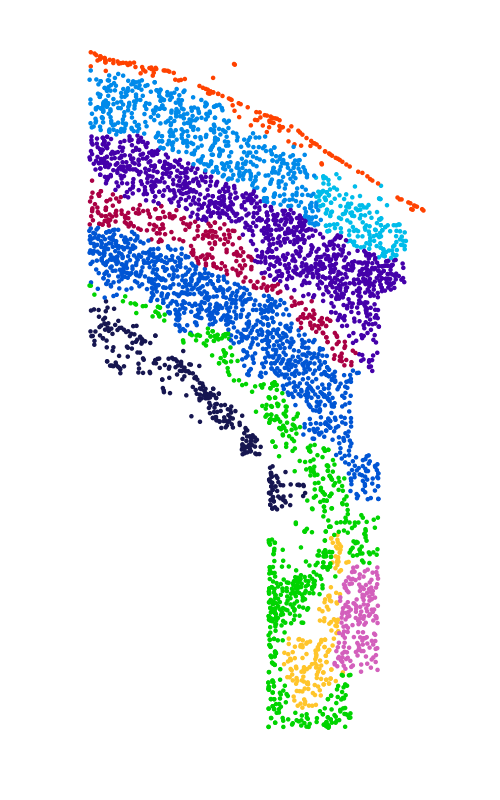

Number of labels: 10
Counter({90: 1052, 91: 1047, 94: 704, 54: 593, 95: 310, 79: 308, 96: 189, 27: 175, 68: 172, 63: 150})


In [1212]:
region_colors = {
    63: '#ff4200',
    54: '#008aea',
    96: '#00bcea',
    90: '#4400AA',
    95: '#AA0044',
    91: '#0055D4',
    94: '#00D400',
    27: '#ffc52a',
    68: '#D35FBC',
    79: '#161650'
    }

def plot_regions(cell_coordinates, label_matrix, level, predefined_labels= True):
    fig, ax = plt.subplots(figsize=(5,8))
    
    if predefined_labels == False:
        c_labels = [list(np.unique(label_matrix.iloc[level])).index(i) for i in label_matrix.iloc[level]]
    else:
        c_labels = [region_colors[i] for i in label_matrix.iloc[level]]
    
    ax.scatter(cell_coordinates.loc['X'], cell_coordinates.loc['Y'], s=5,
              c = c_labels, 
              cmap = 'hsv') 
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.invert_xaxis()
    ax.set_axis_off()
    print('Number of labels: {}'.format(len(np.unique(label_matrix.iloc[level]))))
    print(Counter(label_matrix.iloc[level]))
    plt.tight_layout()
    
plot_regions(df_coord, label_matrix,15) 

plt.savefig('regionalization.png', dpi=300)
cell_labels_regions = dict(zip(label_matrix.columns, label_matrix.iloc[-1]))
pickle.dump(cell_labels_regions, open('cell_label_region.p', 'wb'))
pickle.dump(region_colors, open( "region_colors.p", "wb" ))

<IPython.core.display.Javascript object>


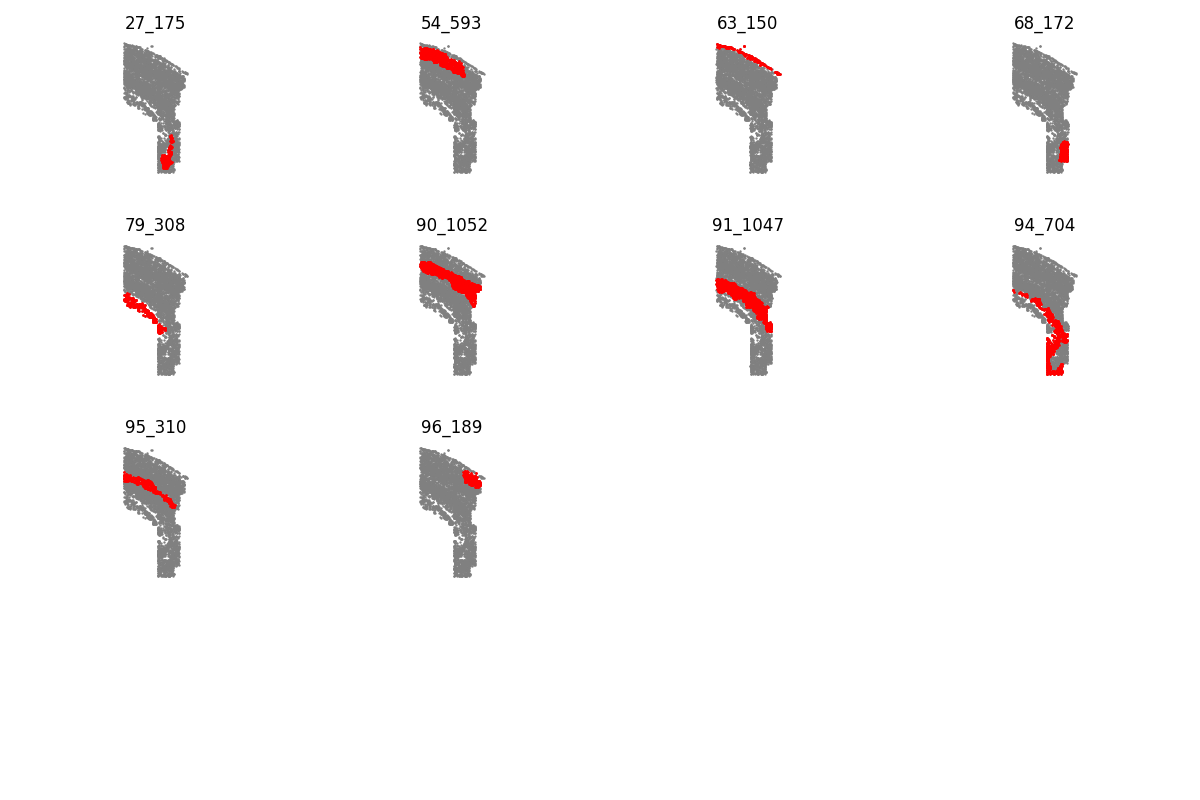

In [1209]:
def plot_region_label(cell_coordinates, label_matrix, level):
    fig = plt.figure(figsize=(12,8))
    gs = plt.GridSpec(4,4)
    
    for n,i in enumerate(np.unique(label_matrix.iloc[level])):
        plt.subplot(gs[n])
        ax=plt.gca()
        filt = label_matrix.iloc[level] == i

        ax.scatter(cell_coordinates.loc['X'], cell_coordinates.loc['Y'], s=.5,c = 'grey')
        ax.scatter(cell_coordinates.loc['X', filt], cell_coordinates.loc['Y',filt], s=1,c = 'red')   
        
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.invert_xaxis()
        ax.set_axis_off()
        ax.set_title('{}_{}'.format(i, Counter(filt)[1]))
    plt.tight_layout()

plot_region_label(df_coord, label_matrix, 15) 

#plt.savefig('Regionalization_individual_areas.png', dpi=300)

In [1002]:
Counter(label_matrix.iloc[-1])[]

Counter({0: 3,
         27: 175,
         54: 593,
         61: 1,
         63: 148,
         68: 172,
         79: 307,
         90: 1052,
         91: 1047,
         94: 703,
         95: 310,
         96: 189})

(2, 503)
503


<IPython.core.display.Javascript object>


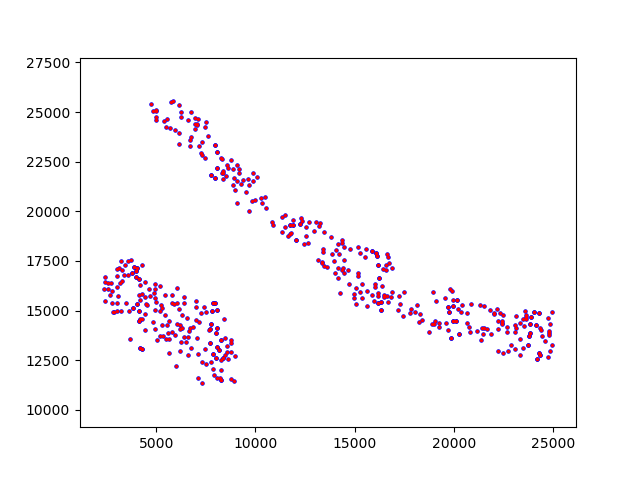

(1160.9401101561991,
 26152.925146388836,
 10564.152540075749,
 26304.888787460932)

In [848]:
filt = label_matrix.iloc[-1] == 55
coord_interest = df_coord.loc[:,filt]
print(coord_interest.shape)

G = nx.Graph()
G.add_nodes_from(coord_interest)
print(len(G.node))
plt.figure()
nx.draw_networkx_nodes(G, df_coord.loc[:,filt], node_size=2)
plt.scatter(df_coord.loc['X', filt], df_coord.loc['Y',filt], s=5,c = 'blue') 
plt.gca().axis('equal')

<IPython.core.display.Javascript object>


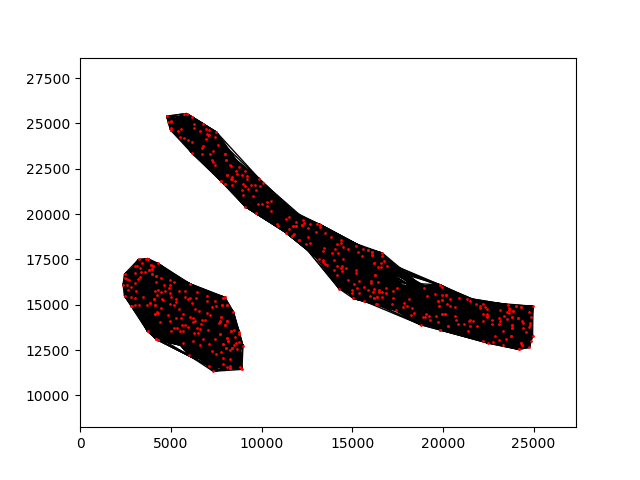

1
1
315
188


In [851]:
def max_dist_graph(coordinates, max_dist=np.inf):
    """
    Build a graph with the coordinates as nodes and edges if the nodes are 
    within the max_dist from each other
    Input:
    `coordinates`(array): Array with the coordinates from each node.
    `max_dist`(float): Max distance nodes can be spaced from each other to 
        be connected.
    Retruns:
    A networkx graph
    
    """
    #Transpose coordinate df if X and Y are in the rows
    if coordinates.shape[0] == 2:
        coordinates = coordinates.T
        
    #Built the KDTree
    nn_tree = scipy.spatial.KDTree(coordinates, leafsize=10)
    
    #Find the pairs of nodes within the max_dist
    cell_pairs = [[coordinates.index[j] for j in i] for i in nn_tree.query_pairs(max_dist)]
    
    #Build the graph
    G = nx.Graph()
    G.add_nodes_from(coordinates)
    G.add_edges_from(cell_pairs)
    
    return G

G3 = max_dist_graph(coord_interest, 3500)
plt.figure()
nx.draw_networkx_edges(G3, coord_interest)    
plt.gca().axis('equal')
plt.scatter(df_coord.loc['X', filt], df_coord.loc['Y',filt], s=1,c = 'red') 

for i in nx.connected_components(G3):
    print(len(i))

In [888]:
label_matrix = copy.copy()

In [864]:
cc = list(nx.connected_components(G3))
cc = [i for i in cc if i not in [{'X'}, {'Y'}]]


[{'2048',
  '2057',
  '2061',
  '2077',
  '2089',
  '2090',
  '2096',
  '2098',
  '2100',
  '2104',
  '2105',
  '2112',
  '2121',
  '2122',
  '2123',
  '2131',
  '2133',
  '2134',
  '2137',
  '2138',
  '2141',
  '2144',
  '2148',
  '2149',
  '2150',
  '2152',
  '2157',
  '2160',
  '2162',
  '2164',
  '2166',
  '2170',
  '2173',
  '2174',
  '2175',
  '2176',
  '2177',
  '2178',
  '2180',
  '2187',
  '2189',
  '2195',
  '2197',
  '2199',
  '2204',
  '2205',
  '2208',
  '2209',
  '2215',
  '2221',
  '2222',
  '2226',
  '2264',
  '3661',
  '3691',
  '3701',
  '3702',
  '3709',
  '3713',
  '3727',
  '3728',
  '3737',
  '3742',
  '3744',
  '3752',
  '3756',
  '3758',
  '3759',
  '3761',
  '3766',
  '3773',
  '3782',
  '3795',
  '3798',
  '3799',
  '3804',
  '3805',
  '3812',
  '3816',
  '3818',
  '3821',
  '3822',
  '3825',
  '3826',
  '3827',
  '3828',
  '3831',
  '3833',
  '3836',
  '3841',
  '3842',
  '3846',
  '3847',
  '3850',
  '3851',
  '3854',
  '3855',
  '3857',
  '3859',
  '3860',


In [902]:
np.unique(label_matrix)[-2]

100

In [904]:
label_matrix = copy.copy()
last_row = label_matrix.index[-1]
label_matrix.append(label_matrix.loc[last_row])
label_matrix.index = label_matrix.index.where((label_matrix.index != last_row), 'post_split')

cc = list(nx.connected_components(G3))
cc = [i for i in cc if i not in [{'X'}, {'Y'}]]
max_label = np.unique(label_matrix)[-2]
for n, c in enumerate(cc):
    label_matrix.loc['post_split', c] = [max_label + n + 1] * len(c)
label_matrix

,1124,2325,2400,241,6248,2573,330,1149,6527,4813,...,821,1217,5162,532,3607,3251,2757,1228,1234,4653
Start,63,91,91,89,78,91,43,94,45,90,...,91,17,87,90,55,94,41,94,94,45
Iteration_1,94,91,91,55,91,91,55,94,79,90,...,91,41,91,90,21,41,79,94,94,54
Iteration_2,94,91,91,55,91,91,55,94,79,90,...,91,41,91,90,21,94,79,94,94,54
Iteration_3,94,91,91,55,91,91,55,94,79,90,...,91,41,91,90,21,94,79,94,94,54
Iteration_4,94,91,91,55,91,91,55,94,79,90,...,91,41,91,90,21,94,79,94,94,54
Iteration_5,94,91,91,55,91,91,55,94,79,90,...,91,9999,91,90,9999,94,79,94,94,54
Iteration_6,94,91,91,55,91,91,55,94,79,90,...,91,0,91,90,0,94,79,94,94,54
Iteration_7,94,91,91,55,91,91,55,94,79,90,...,91,94,91,90,54,94,79,94,94,54
Iteration_8,94,91,91,55,91,91,55,94,79,90,...,91,94,91,90,54,94,79,94,94,54
Iteration_9,94,91,91,55,91,91,55,94,79,90,...,91,94,91,90,90,94,79,94,94,54


In [905]:
Counter(label_matrix.loc['post_split'])

Counter({0: 2,
         27: 141,
         54: 561,
         63: 159,
         68: 169,
         79: 302,
         90: 1056,
         91: 1054,
         94: 753,
         95: 315,
         96: 188})

In [882]:
label_matrix

,1124,2325,2400,241,6248,2573,330,1149,6527,4813,...,821,1217,5162,532,3607,3251,2757,1228,1234,4653
Start,63.0,91.0,91.0,89.0,78.0,91.0,43.0,94.0,45.0,90.0,...,91.0,17.0,87.0,90.0,55.0,94.0,41.0,94.0,94.0,45.0
Iteration_1,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,41.0,91.0,90.0,21.0,41.0,79.0,94.0,94.0,54.0
Iteration_2,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,41.0,91.0,90.0,21.0,94.0,79.0,94.0,94.0,54.0
Iteration_3,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,41.0,91.0,90.0,21.0,94.0,79.0,94.0,94.0,54.0
Iteration_4,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,41.0,91.0,90.0,21.0,94.0,79.0,94.0,94.0,54.0
Iteration_5,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,9999.0,91.0,90.0,9999.0,94.0,79.0,94.0,94.0,54.0
Iteration_6,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,0.0,91.0,90.0,0.0,94.0,79.0,94.0,94.0,54.0
Iteration_7,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,94.0,91.0,90.0,54.0,94.0,79.0,94.0,94.0,54.0
Iteration_8,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,94.0,91.0,90.0,54.0,94.0,79.0,94.0,94.0,54.0
Iteration_9,94.0,91.0,91.0,55.0,91.0,91.0,55.0,94.0,79.0,90.0,...,91.0,94.0,91.0,90.0,90.0,94.0,79.0,94.0,94.0,54.0


In [ ]:
    def reset_labels(label_matrix, count_threshold, reset_to_9999=False):

        label_matrix = label_matrix.T
        first_label = label_matrix.index[0]
        last_label = label_matrix.index[-1]
        new_label = 'Reset_labels'
        for i in np.unique(label_matrix.iloc[-1]):
            if list(label_matrix.iloc[-1]).count(i) < count_threshold:
                filt = label_matrix.iloc[-1] == i
                if reset_to_9999 == False:
                    label_matrix.loc[last_label,filt] = label_matrix.loc[first_label,filt]
                else:
                    label_matrix.loc[last_label,filt] = [9999] * label_matrix.loc[last_label].value_counts()[i]
        return label_matrix.loc[last_label,:].astype('Int64')
    
    label_matrix = pd.DataFrame(data=labels, columns=['Start'], 
                                index=cell_coordinates.columns, dtype='Int64')

In [677]:
df_coord.index[0]

'X'

In [706]:
def reset_islands(label_matrix, coordinates, max_dist=1000, minimal_group = 100, reset_to_9999=Flase):
    #Uncomment:
    #label_matrix = label_matrix.T
    #Comment:
    coordinates = coordinates.T
    
    first_label = label_matrix.index[0]
    last_label = label_matrix.index[-1]
    for i in np.unique(label_matrix.iloc[-1]):
        filt = label_matrix.iloc[-1] == i
        coi = coordinates.loc[filt]
        G = max_dist_graph(coi, max_dist=max_dist)
        for group in nx.connected_components(G):
            if group == {coordinates.index[0]} or group == {coordinates.index[1]}:
                pass
            else:
                if len(group) < minimal_group:
                    for item in group:
                        if reset_to_9999 == True:
                            label_matrix.loc[last_label, item] = 9999
                        else:
                            label_matrix.loc[last_label, item] = label_matrix.loc[first_label, item]

                            
reset_islands(label_matrix, df_coord, max_dist=5000, minimal_group=75)        

0
(34, 2)
Group  1
Group  1
Group  28
Group  3


27
(143, 2)
Group  1
Group  1
Group  115
Group  19
Group  9


54
(731, 2)
Group  1
Group  1
Group  721
Group  10


61
(49, 2)
Group  1
Group  1
Group  20
Group  16
Group  11
Group  2


63
(130, 2)
Group  1
Group  1
Group  117
Group  11
Group  2


68
(159, 2)
Group  1
Group  1
Group  121
Group  9
Group  19
Group  8
Group  2


69
(59, 2)
Group  1
Group  1
Group  40
Group  10
Group  6
Group  3


79
(246, 2)
Group  1
Group  1
Group  246


87
(336, 2)
Group  1
Group  1
Group  323
Group  13


90
(1075, 2)
Group  1
Group  1
Group  1075


91
(933, 2)
Group  1
Group  1
Group  933


94
(805, 2)
Group  1
Group  1
Group  805




In [686]:
Counter(lm.iloc[-1])

Counter({0: 30,
         27: 143,
         54: 731,
         61: 49,
         63: 118,
         68: 157,
         69: 53,
         79: 246,
         87: 336,
         90: 1075,
         91: 933,
         94: 794,
         9999: 35})

In [563]:
nn_tree = scipy.spatial.KDTree(coord_interest.T, leafsize=10)

In [481]:
nn_tree.query_ball_tree(nn_tree, 1000)[0]

[0, 10, 15, 17, 22, 23, 40, 8]

In [506]:
coord_interest.columns[1]

'2673'

In [507]:
a =[[27,28], [26,45]]

[[coord_interest.columns[j] for j in i] for i in a]

[['5393', '5394'], ['3244', '2987']]

In [564]:
cell_pairs = [[coord_interest.columns[j] for j in i] for i in nn_tree.query_pairs(1500)]

In [489]:
G2.add_edges_from(cell_pairs)

<IPython.core.display.Javascript object>


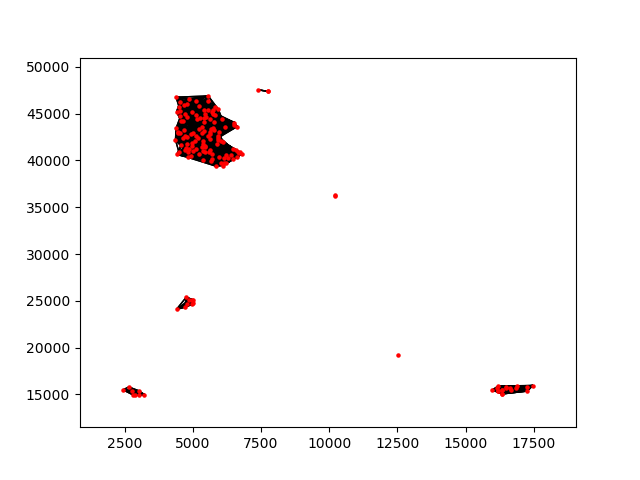

In [565]:
plt.figure()
G2 = G
#G2.add_edge('3230', '2673')
#G2.add_edges_from(nn_tree.query_pairs(1000))
G2.add_edges_from(cell_pairs)
nx.draw_networkx_edges(G2, coord_interest, )
nx.draw_networkx_nodes(G2, coord_interest, node_size=5)

In [577]:
sub_networks = list(nx.connected_components(G2))
for i in sub_networks:
    print(len(i))
    if len(i) < 10:
        print(i)

118
18
8
{'29', '24', '28', '23', '22', '15', '18', '30'}
9
{'741', '740', '736', '737', '738', '739', '599', '735', '586'}
2
{'2852', '2851'}
3
{'1501', '3076', '1515'}
1
{'3799'}


In [580]:
'29' in coord_interest.columns

True

In [571]:
sub_networks.sort(key=len, reverse=True)
for i in sub_networks:
    print(len(i))

118
18
9
8
3
2
1


# Cortex regionalization Graph

In [393]:
import shapely